# Wiebe vs Weiss!!
A thorough computational comparison of the two methods for finding complementary polynomials

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
from qsppack import nlfa

from matplotlib import pyplot as plt
import numpy as np
from numpy.polynomial import chebyshev as cheb
from scipy.signal import convolve

First, we set up the necessary functions for probing the Weiss algorithm.

In [33]:
def obj(a, b):
        delta = np.zeros(2*len(a)-1)
        delta[len(a)-1] = 1

        a_convolved = convolve(a, a[::-1], mode='full')
        b_convolved = convolve(b, b[::-1], mode='full')

        result = a_convolved + b_convolved - delta
        return np.linalg.norm(result, ord=2)**2


def probe_weiss(dim, trials, granularity=2**9):
    # initialize prerequisites
    times = np.zeros(trials)
    obj_vals = np.zeros(trials)

    # loop over trials
    for i in range(trials):
        b = (np.random.rand(dim) * 2 - 1) / dim
        start = time.time()
        a = nlfa.weiss(b, granularity)
        end = time.time()
        times[i] = end - start
        obj_vals[i] = obj(a, b)

        # plot aa^* + bb^* for a single trial
        if trials == 1:
            coefs_constraint = convolve(a, np.flip(np.conj(a)), mode='full') + convolve(b, np.flip(np.conj(b)), mode='full')
            xvals = np.linspace(-1, 1, len(coefs_constraint))
            plt.plot(xvals, np.real(coefs_constraint))
            plt.yscale("log")
            plt.title(r"$aa^* + bb^*$")
            plt.show()

    return np.mean(times), np.mean(obj_vals)


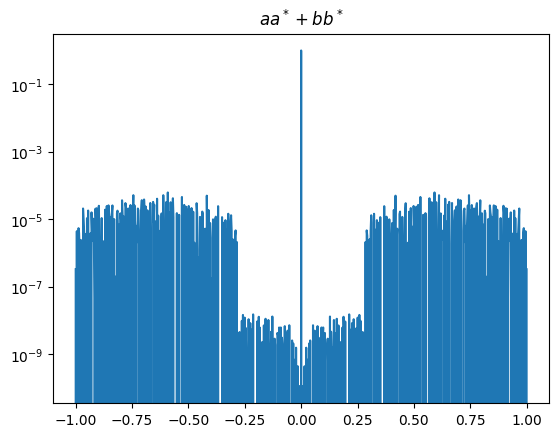

(0.07775521278381348, 1.970025230391971e-07)

In [7]:
probe_weiss(400,1)

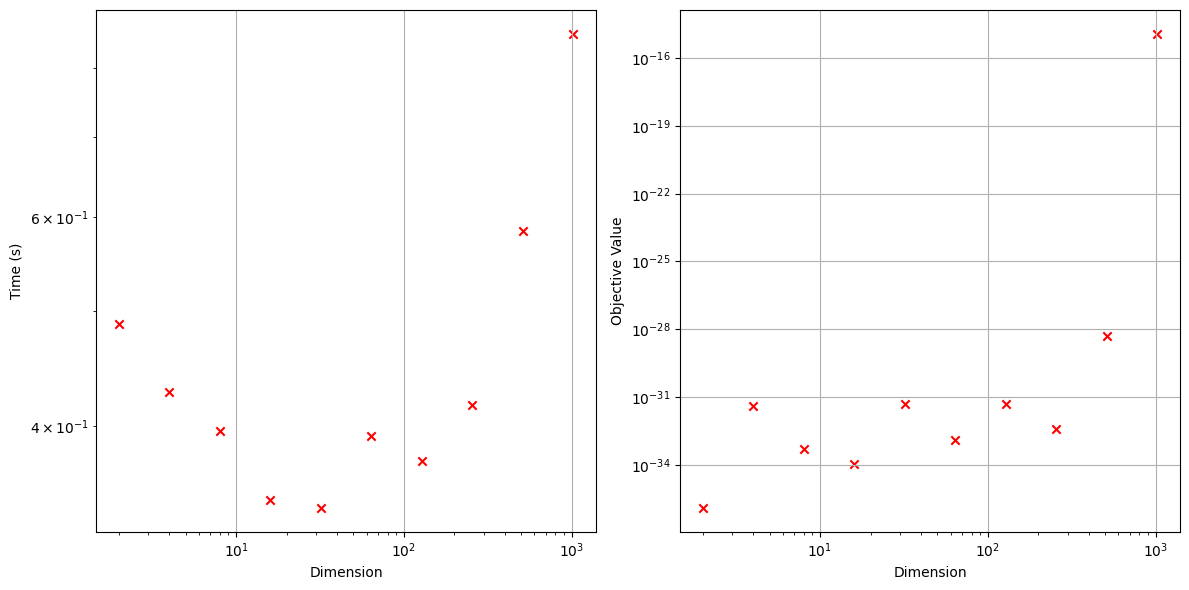

In [24]:
dims = 2**np.arange(1, 11)
trials = 10
times = np.zeros(len(dims))
obj_vals = np.zeros(len(dims))
granularity = 2**11
for i, dim in enumerate(dims):
    times[i], obj_vals[i] = probe_weiss(dim, trials, granularity)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Time to find a for Weiss
axs[0].scatter(dims, times, color="red", marker="x")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Dimension")
axs[0].set_ylabel("Time (s)")
axs[0].grid(True)

# Plot for Objective value for Weiss
axs[1].scatter(dims, obj_vals, color="red", marker="x")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Dimension")
axs[1].set_ylabel("Objective Value")
axs[1].grid(True)

plt.tight_layout()
plt.show()

Next, we set up the Wiebe algorithm probe.

In [90]:
def probe_wiebe(dim, trials):
    times = np.zeros(trials)
    obj_vals = np.zeros(trials)

    # Define the objective function
    def objective_torch(x, P):
        """
        Computes the loss for the optimization problem.

        This function calculates the loss as the squared norm of the difference
        between the target tensor P and the convolution of x with its flipped version.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor for which the loss is computed.
        P : torch.Tensor
            The target tensor to compare against.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        x.requires_grad = True

        # Compute loss using squared distance function
        loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
        return loss
    

    # loop over trials
    for i in range(trials):

        # Set up optimizer
        b = (np.random.rand(dim) * 2 - 1) / dim
        poly = torch.tensor(b, dtype=torch.float32, device=device)
        initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
        initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
        optimizer = torch.optim.LBFGS([initial], max_iter=2000, tolerance_grad=1e-15, tolerance_change=1e-15)
        # optimizer = torch.optim.SGD([initial], lr=1e-5, momentum=0.8, nesterov=True) # much worse...

        # # Define the granularity for padding
        # granularity = 2 ** 25
        # P = pad(poly, (0, granularity - poly.shape[0]))
        # ft = fft(P)

        # # Normalize P
        # P_norms = ft.abs()
        # poly /= torch.max(P_norms)
        conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1
        conv_p_negative[poly.shape[0] - 1] = 1 + conv_p_negative[poly.shape[0] - 1]
        def closure():
            """
            Closure function for the optimizer.

            This function zeroes the gradients, computes the loss using the objective_torch
            function, and performs backpropagation to compute the gradients.

            Returns
            -------
            torch.Tensor
                The computed loss value.
            """
            optimizer.zero_grad()
            loss = objective_torch(initial, conv_p_negative)
            loss.backward()
            return loss

        # Perform optimization step and record time
        start = time.time()
        optimizer.step(closure)
        end = time.time()
        times[i] = end - start
        # obj_vals[i] = closure().item()
        # a = optimizer._params[0].detach().cpu().numpy()
        a = initial.detach().cpu().numpy()
        obj_vals[i] = obj(a, b)

        # plot aa^* + bb^* for a single trial
        if trials == 1:
            coefs_constraint = convolve(a, np.flip(np.conj(a)), mode='full') + convolve(b, np.flip(np.conj(b)), mode='full')
            xvals = np.linspace(-1, 1, len(coefs_constraint))
            plt.plot(xvals, np.real(coefs_constraint))
            plt.yscale("log")
            plt.title(r"$aa^* + bb^*$")
            plt.show()

    return np.mean(times), np.mean(obj_vals)

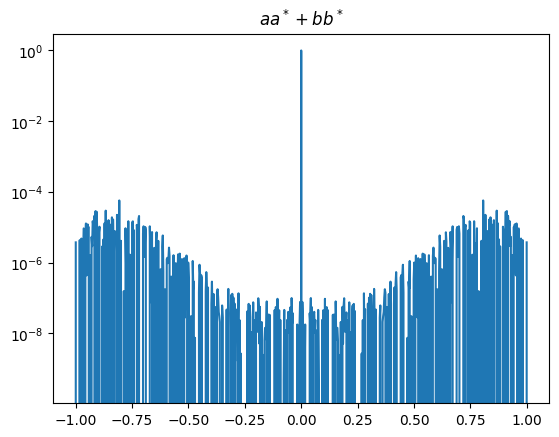

(20.334541082382202, 5.106986721990729e-08)

In [91]:
probe_wiebe(400, 1)

In [63]:
dims = 2**np.arange(1, 9)
trials = 3
times_weiss = np.zeros(len(dims))
obj_vals_weiss = np.zeros(len(dims))
times_wiebe = np.zeros(len(dims))
obj_vals_wiebe = np.zeros(len(dims))

granularity = 2**11
for i, dim in enumerate(dims):
    print(f"Running Weiss for dim={dim}...")
    times_weiss[i], obj_vals_weiss[i] = probe_weiss(dim, trials, granularity)
    print(f"Running Wiebe for dim={dim}...")
    times_wiebe[i], obj_vals_wiebe[i] = probe_wiebe(dim, trials)

Running Weiss for dim=2...
Running Wiebe for dim=2...
Running Weiss for dim=4...
Running Wiebe for dim=4...
Running Weiss for dim=8...
Running Wiebe for dim=8...
Running Weiss for dim=16...
Running Wiebe for dim=16...
Running Weiss for dim=32...
Running Wiebe for dim=32...
Running Weiss for dim=64...
Running Wiebe for dim=64...
Running Weiss for dim=128...
Running Wiebe for dim=128...
Running Weiss for dim=256...
Running Wiebe for dim=256...


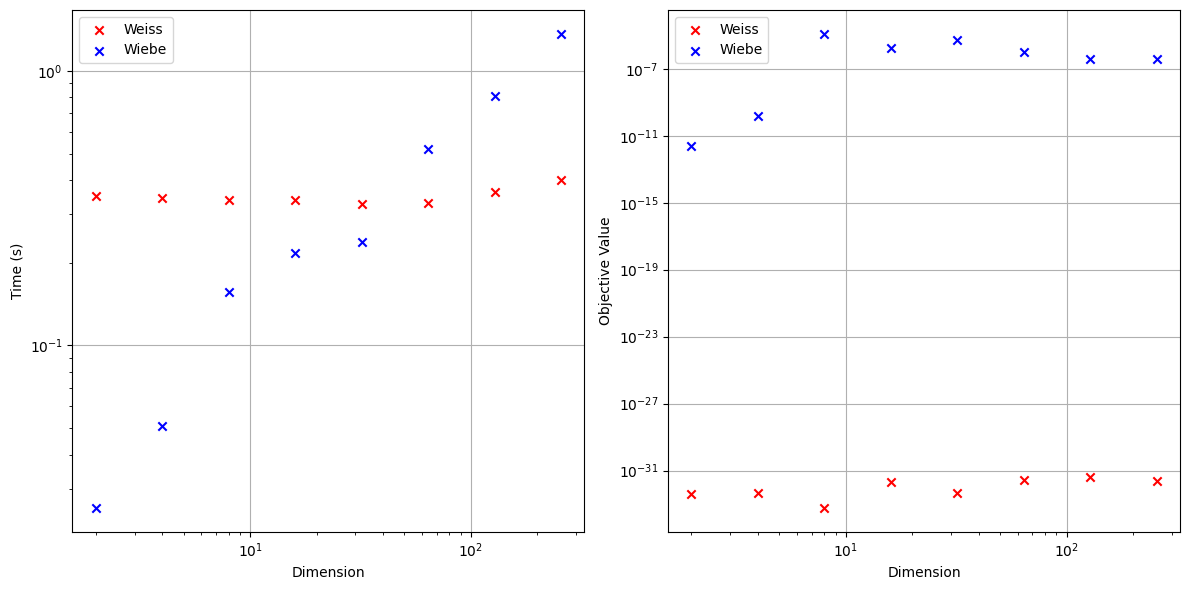

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Time to find a
axs[0].scatter(dims, times_weiss, color="red", marker="x", label="Weiss")
axs[0].scatter(dims, times_wiebe, color="blue", marker="x", label="Wiebe")
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Dimension")
axs[0].set_ylabel("Time (s)")
axs[0].grid(True)
axs[0].legend()

# Plot for Objective value
axs[1].scatter(dims, obj_vals_weiss, color="red", marker="x", label="Weiss")
axs[1].scatter(dims, obj_vals_wiebe, color="blue", marker="x", label="Wiebe")
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Dimension")
axs[1].set_ylabel("Objective Value")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig("Wiebe_vs_Weiss.png")